In [137]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy.lib.function_base import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json

In [138]:
sns.set_style("whitegrid") 
sns.set_context("paper")

# Packet Processing Time

In [139]:
raw_df = pd.read_csv("../log/stat.log")
raw_df['time'] = raw_df['time'] - raw_df['time'].min()
raw_df.head()

,time,level,file,line,msg,pkt_count,tcp_pkt_count_tot,udp_pkt_count_tot,icmp_pkt_count_tot,unsupported_pkt_count,...,replied_flow_count_tcp,replied_flow_count_udp,replied_flow_count_icmp,expired_pkt_count_tot,expired_pkt_count_tcp,expired_pkt_count_udp,expired_pkt_count_icmp,tcp_flow_entry_count,udp_flow_entry_count,icmp_flow_entry_count
0,0.000000,STATS,src/tsdn.c,458,stats,739,538.0,200.0,1.0,0.0,...,35.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002250,STATS,src/tsdn.c,476,pkt_processing_time,1000,21.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.010027,STATS,src/tsdn.c,458,stats,1985,1365.0,619.0,1.0,0.0,...,82.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.010139,STATS,src/tsdn.c,476,pkt_processing_time,2000,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.016291,STATS,src/tsdn.c,476,pkt_processing_time,3000,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
stats_df = raw_df[raw_df['msg'] == 'stats']

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
print(pkt_process_time_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
print(timeout_df.head())

       time  sample_at  pkt_process_time
1  0.002250       1000              21.0
3  0.010139       2000              15.0
4  0.016291       3000               7.0
6  0.022417       4000               9.0
7  0.028696       5000              32.0
         time  timeout
28   0.100535    33741
52   0.181078    35970
75   0.261732    26123
100  0.352625    26732
129  0.453466    30806


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

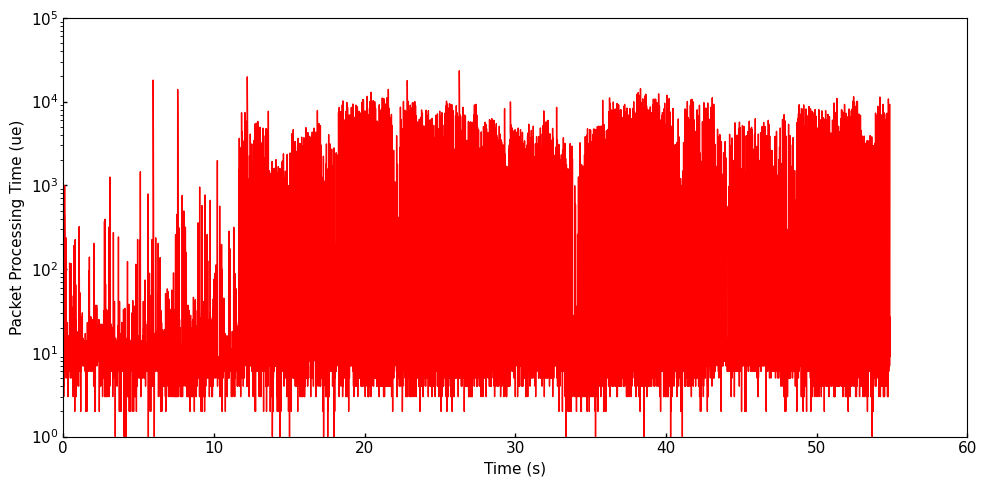

In [141]:
fastplot.plot((pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time']), None, mode='line',
              yscale='log',
              figsize=(10, 5), xlabel='Time (s)', ylabel='Packet Processing Time (ue)')

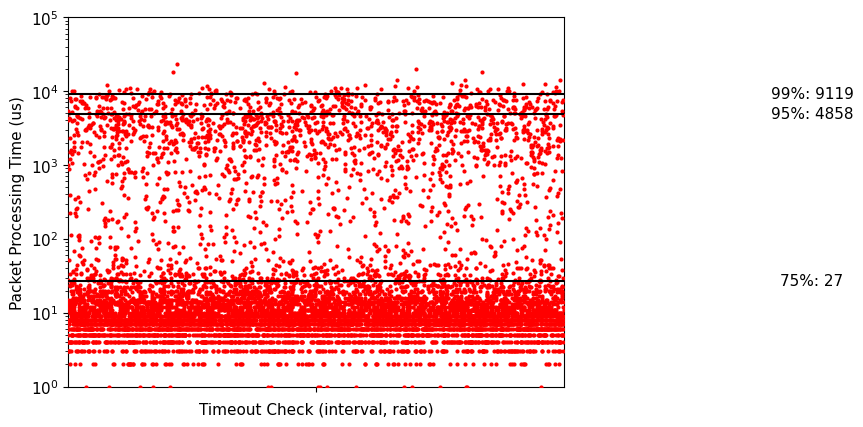

In [142]:
sns.stripplot(y='pkt_process_time', 
              size=3, legend=False,
              data=pkt_process_time_df, jitter=0.2)
plt.ylabel('Packet Processing Time (us)')
plt.xlabel('Timeout Check (interval, ratio)')
plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = pkt_process_time_df['pkt_process_time'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))

# adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)


# Timeout Bias (real buffered time (avg) - expected buffered time)

([Text(0.16275201612903223, 34900.66233766234, '75%: 35063'),
  Text(0.16275201612903223, 38398.79935064935, '95%: 39048'),
  Text(0.16265120967741936, 40306.744155844164, '99%: 39901')],
 [])

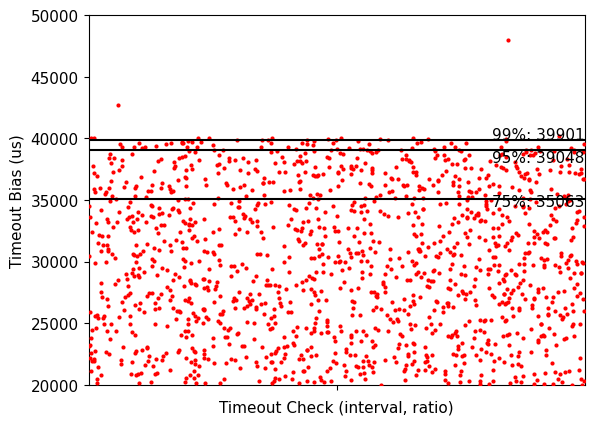

In [143]:
sns.stripplot(y='timeout', 
              size=3, legend=False,
              data=timeout_df, jitter=0.2)
plt.ylabel('Timeout Bias (us)')
plt.xlabel('Timeout Check (interval, ratio)')
# plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = timeout_df['timeout'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))
    
adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

# Data Structure Usage

In [144]:
from cycler import cycler

mcolor_lists = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:green','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rosybrown', 'tomato', 'yellowgreen', 'lightseagreen', 'navy', 'deeppink',
                'darkslategray', 'darkolivegreen', 'darkcyan', 'darkviolet', 'mediumslateblue', 'darkorange', 'gold', 'peru', 'darkkhaki']
CYCLER_LINES=(cycler('color', mcolor_lists[:30]) +
              cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--', '-.', ':', (0, (10, 6)), (0, (6, 10)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)), (0, (3, 1, 1, 1)),
                                   '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 10)), (0,
                                                                                           (10, 6)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)),
                                   '-', '--', '-.', ':']))

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

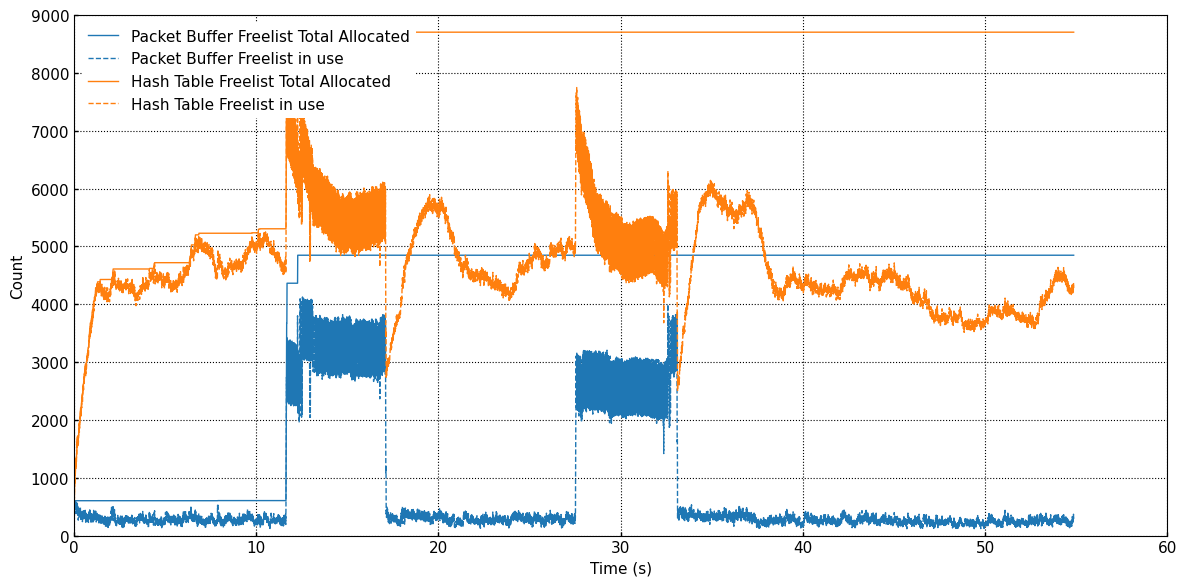

In [145]:
# buffered packet count

fastplot.plot([('Packet Buffer Freelist Total Allocated', (stats_df['time'], stats_df['pkt_list_count_tot'])),
              ('Packet Buffer Freelist in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
               ('Hash Table Freelist Total Allocated', (stats_df['time'], stats_df['flow_hash_list_count_tot'])),
              ('Hash Table Freelist in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              cycler=CYCLER_LINES,
              xlabel='Time (s)', 
              ylabel='Count')


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

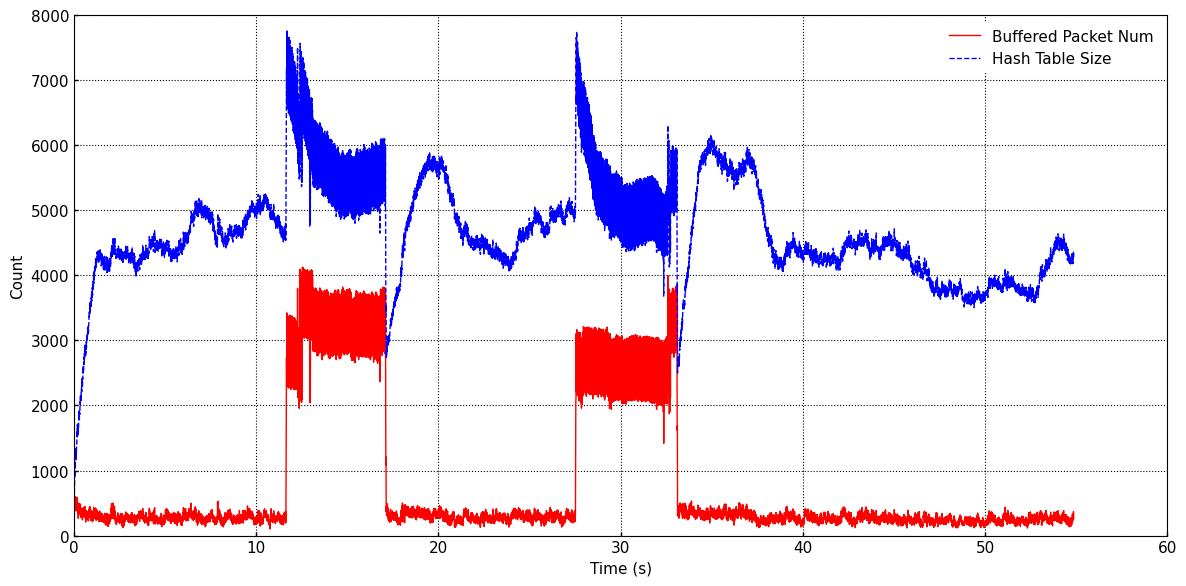

In [146]:
# buffered packet count

fastplot.plot([('Buffered Packet Num', (stats_df['time'], stats_df['pkt_buf_count'])),
              ('Hash Table Size', (stats_df['time'], stats_df['flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')


# Data Plane Resource Usage

## Table Entry Count

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

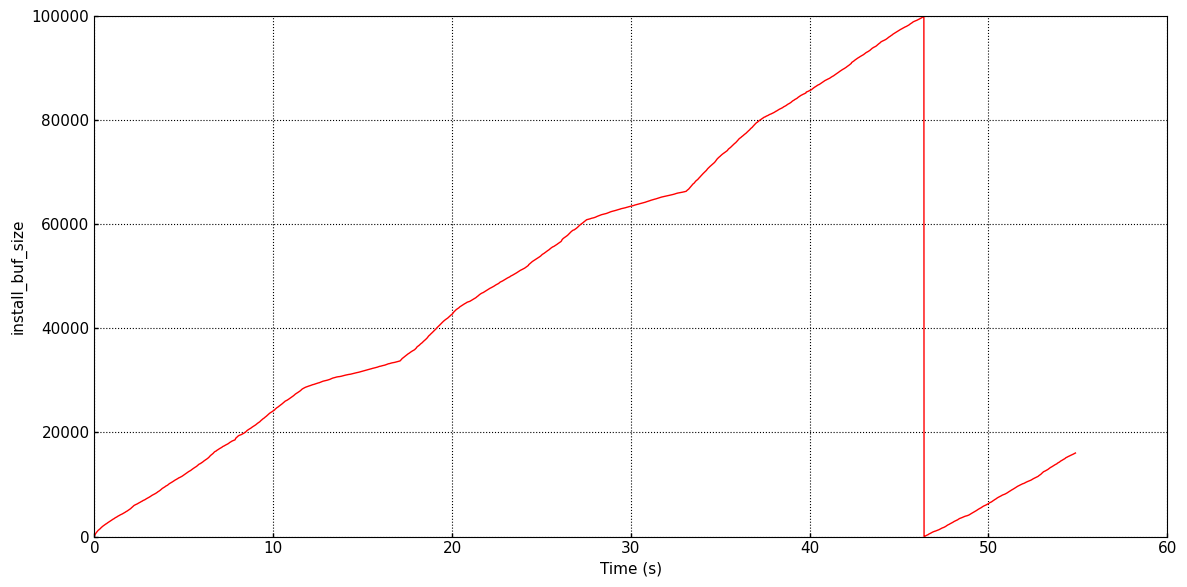

In [147]:
fastplot.plot((stats_df['time'], stats_df['install_buf_size']),
                None,
                mode='line',
                legend_loc='best',
                figsize=(12, 6), grid=True,
                xlabel='Time (s)', 
                ylabel='install_buf_size')

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

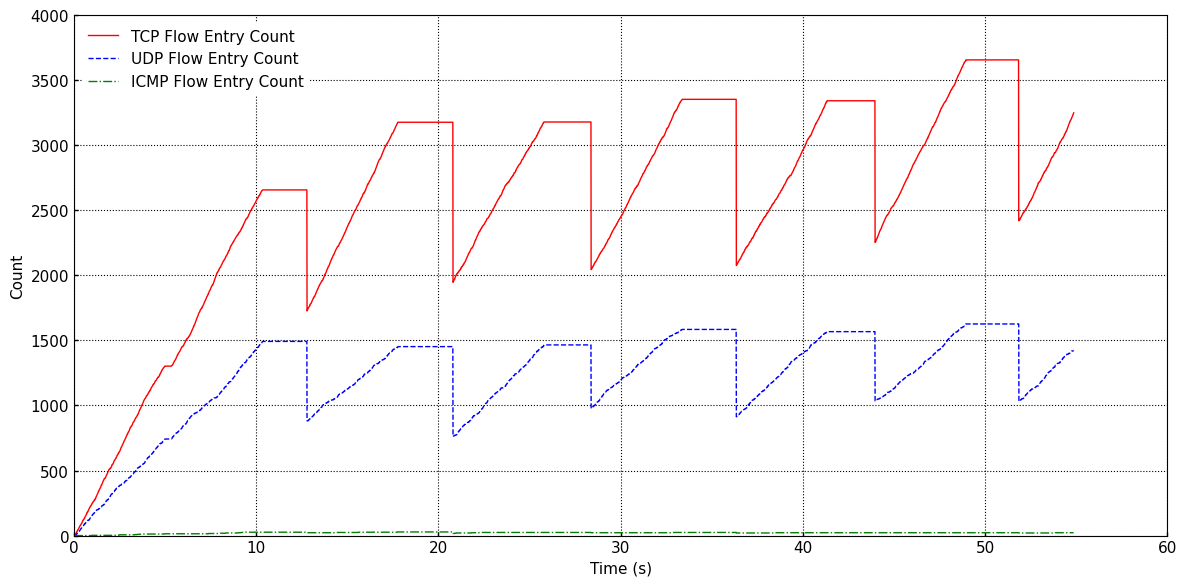

In [148]:

fastplot.plot([('TCP Flow Entry Count', (stats_df['time'], stats_df['tcp_flow_entry_count'])),
              ('UDP Flow Entry Count', (stats_df['time'], stats_df['udp_flow_entry_count'])),
              ('ICMP Flow Entry Count', (stats_df['time'], stats_df['icmp_flow_entry_count'])),],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(12, 6), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')

# Network Speed Statistic

In [149]:
# net_speed_df = []

# with open('../log/speed_log.json', 'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         if 'jsonversion' not in line and 'maxratestring' not in line:
#             line = json.loads(line)
#             net_speed_df.append({'time': line['seconds'], 'rx_speed': line['rx']['ratestring']})

# net_speed_df = pd.DataFrame(net_speed_df)
# net_speed_df['rx_speed'] = net_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' Kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
# net_speed_df['rx_speed'] = net_speed_df['rx_speed'].astype(float)
# net_speed_df.head()

In [150]:
# fastplot.plot((net_speed_df['time'], net_speed_df['rx_speed']),
#                 None,
#                 mode='line',
#                 legend=True, legend_loc='best',
#                 figsize=(12, 6), grid=True,
#                 xlabel='Time (s)', 
#                 ylabel='Speed (Gbps)')